In [2]:
import torch
import torch.nn as nn
from torch.autograd import Variable
from torchvision import models
from torchvision import transforms, utils
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image, ImageFilter, ImageChops
#该库全名为Pytorch Image Library

# 编写加载图片的函数

In [3]:
def load_image(path):
    image = Image.open(path)
    plt.show(image)
    return image

# 初步定义一个自己的vgg网络

In [4]:
class ChrisXue_Dream:
    def __init__(self,image):
        self.image = image  #定义图片的变量
        self.model = models.vgg16(pretrained=True)  #定义一个已经预训练好的vgg16网络
        self.modules = list(self.model.features.modules())
        
        #vgg16要求224*224的输入图片
        length = 224
        width = 224
        
        #编写图像预处理模块
        self.trans_mean = [0.485,0.456,0.406]
        self.trans_std = [0.229,0.224,0.225]
        self.normalize = transforms.Normalize(mean=self.trans_mean,std=self.trans_std)
        self.trans_Preprocess = transforms.Compose([
            transforms.Resize(size=(length,width)),
            transforms.ToTensor(),
            self.normalize
        ])
        
        #将mean和std转换为Tensor类型
        self.tensor_maen = torch.Tensor(self.trans_mean)
        self.tensor_std = torch.Tensor(self.trans_std)
     
    #把处理后的图片变回去
    def ToImage(self,x):
        out = x*self.tensor_std + self.tensor_maen
        return out

# 查看VGG16的结构（便于选择layers的数目）

In [15]:
Net_check = models.vgg16()
print(Net_check)

VGG(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU(inplace)
    (2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU(inplace)
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (6): ReLU(inplace)
    (7): Conv2d(128, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (8): ReLU(inplace)
    (9): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (10): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace)
    (12): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (13): ReLU(inplace)
    (14): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (15): ReLU(inplace)
    (16): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (17): Conv2d

# 搭建梦境

In [5]:
class ChrisXue_Dream(ChrisXue_Dream):
    def MakeDream(self,image,layers,iterations,lr):
        trans = self.trans_Preprocess(image).unsqueeze(0)
        #满足VGG16的输入要求，将其变为1*3*224*224的Tensor
        input = Variable(trans,requires_grad = True)
        self.model.zero_grad() 
        #将模型中的梯度清空
        for i in range(iterations):
            out = input
            for layerID in range(layers):
                out = self.modules[layerID+1](out)
                #layers的数目取决于自己想要多少个神经层的输出
            loss = out.norm()
            #求其损失函数，即是所有像素点的二范数L2，将其最大化
            loss.backward()
            #反向传播，求梯度
            input.data = input.data + lr*input.grad.data
            #因为是最大化L2，所以反向梯度下降（梯度上升）
        
        input = input.data.squeeze()
        #将其扁平化，变为3*224*224
        input.transpose_(0,1)
        #交换维度，变为224*3*224
        input.transpose_(1,2)
        #交换维度，变为224*224*3,为了满足To_image函数的输入要求
        input = np.clip(self.ToImage(input),0,1)
        #将像素点的值缩小到0~1之间,大于1的变为1，小于0的变为0
        return Image.fromarray(np.uint8(input*255))
    
    #采用递归的方法对图片进行降采样，不断地提取特征并融合，使得特征更明显，梦境更真实
    def MoreDream(self,image,layers,iterations,lr,num_downscales):
        if num_downscales>0:
            im_small = image.filter(ImageFilter.GaussianBlur(2))#采用大小为2的高斯核进行降采样
            small_size = (int(image.size[0]/2),int(image.size[1]/2))
            if(small_size[0]==0 or small_size[1]==0):
                small_size = image.size
            im_samll = im_small.resize(small_size,Image.ANTIALIAS)
            
            #递归
            im_small = self.MoreDream(im_small,layers,iterations,lr,num_downscales-1)
            
            #放大回去
            image_back = im_small.resize(image.size,Image.ANTIALIAS)
            #合并图像
            image = ImageChops.blend(image,image_back,0.6)
        
        im_out = self.MakeDream(image,layers,iterations,lr)
        im_out = im_out.resize(image.size)
        return im_out
      
    def BeginDream(self,image,layers,iterations,lr,num_dowmscales):
        return self.MoreDream(image,layers,iterations,lr,num_dowmscales)
        
    

# 了解图像处理的具体size变换（辅助理解代码思想）

torch.Size([1, 3, 224, 224])
torch.Size([3, 224, 224])
torch.Size([224, 3, 224])
torch.Size([224, 224, 3])


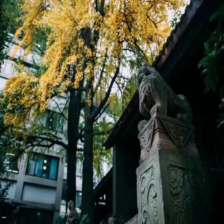

In [10]:
x = mynet.trans_Preprocess(my_son)
x = x.unsqueeze(0)
print(x.size())
x = x.squeeze()
print(x.size())
x.transpose_(0,1)
print(x.size())
x.transpose_(1,2)
print(x.size())
k = mynet.ToImage(x)
k = np.clip(k,0,1)
Image.fromarray(np.uint8(k*255))

# 加载图片

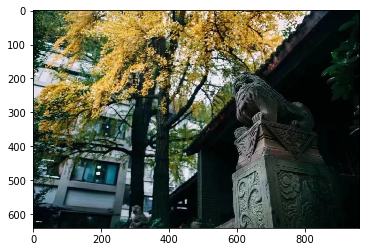

In [19]:
image =  load_image(path='C:/Users/liu/Desktop/shishi1.png')
plt.imshow(image)

In [17]:
mynet = ChrisXue_Dream(image=image)

In [18]:
image_dream=mynet.BeginDream(image=image,iterations=5,layers=21,lr=0.02,num_dowmscales=15)

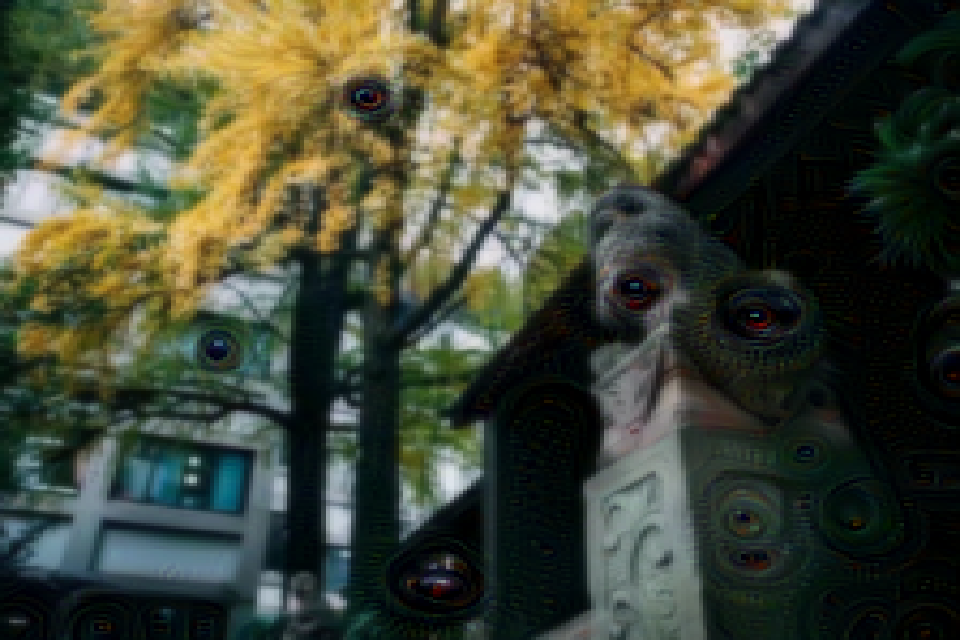

In [21]:
image_dream